
# Natural Language Processing


## Introduction

This is a basic form of Natural Language Processing (NLP) called Sentiment Analysis, in which we will try and classify a movie review as either positive or negative.


## Flowchart

To solve this problem we need several processing steps. First we need to convert the raw text-words into so-called tokens which are integer values. These tokens are really just indices into a list of the entire vocabulary. Then we convert these integer-tokens into so-called embeddings which are real-valued vectors, whose mapping will be trained along with the neural network, so as to map words with similar meanings to similar embedding-vectors. Then we input these embedding-vectors to a Recurrent Neural Network which can take sequences of arbitrary length as input and output a kind of summary of what it has seen in the input. This output is then squashed using a Sigmoid-function to give us a value between 0.0 and 1.0, where 0.0 is taken to mean a negative sentiment and 1.0 means a positive sentiment. This whole process allows us to classify input-text as either having a negative or positive sentiment.

The flowchart of the algorithm is roughly:

<img src="images/natural_language_flowchart.png" alt="Flowchart NLP" style="width: 300px;"/>

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd
import os
import re

We need to import several things from Keras.

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
#from keras.datasets import imdb

This was developed using Python 3.6 (Anaconda) and package versions:

In [56]:
tf.__version__

'1.7.0'

In [57]:
tf.keras.__version__

'2.1.4-tf'

## Load Data

We will use a data-set consisting of 50000 reviews of movies from IMDB. Keras has a built-in function for downloading a similar data-set (but apparently half the size). However, Keras' version has already converted the text in the data-set to integer-tokens, which is a crucial part of working with natural languages.

NOTE: The data-set is 84 MB and will be downloaded automatically.

In [3]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)



In [4]:
# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)


In [5]:
# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df



In [6]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()


84131840/84125825 [==============================] - 28s 0us/step

,sentence,sentiment,polarity
0,"Eh, not a particular good slasher flick. So-so...",4,0
1,I never really knew who Robert Wuhl was before...,10,1
2,This is an interesting left turn for Reel 13 I...,3,0
3,"Lynn Hollister, a small-town lawyer, travels t...",3,0
4,The Western society has been fed ideas about I...,2,0


In [8]:
print("Train-set size: ", len(train_df))
print("Test-set size:  ", len(test_df))

Train-set size:  25000
Test-set size:   25000


In [0]:
x_train_text = train_df.iloc[:,0].tolist()

In [0]:
y_train = train_df.iloc[:,2].tolist()

In [0]:
x_test_text = test_df.iloc[:,0].tolist()
y_test = test_df.iloc[:,2].tolist()

In [70]:
print("Train-set size: ", len(x_train_text))
print("Test-set size:  ", len(x_test_text))

Train-set size:  25000
Test-set size:   25000


In [0]:
data_text = x_train_text + x_test_text

In [72]:
x_train_text[1]

"OK, I overrated it just a bit to offset at least one of those grumpy reviews. But I did enjoy it. I didn't laugh out loud, but it held my interest and pulled me along without dropping me at any point. The story built. Yeah, you knew it would have an happy ending--this genre always does. Meantime, it was quirky with sight gags you could miss, so pay attention when you watch. Stiller and Black delivered expertly yet again. Good team. They should work together more. Don't know that it will be a cult classic, but it was certainly a fun ride. Not as good as WHAT ABOUT BOB, or DIRTY ROTTEN SCOUNDRELS but what is? It is still worth going out of your way a little to get and watch this movie."

In [73]:
y_train[1]

1

## Tokenizer

A neural network cannot work directly on text-strings so we must convert it somehow. There are two steps in this conversion, the first step is called the "tokenizer" which converts words to integers and is done on the data-set before it is input to the neural network. The second step is an integrated part of the neural network itself and is called the "embedding"-layer, which is described further below.

We may instruct the tokenizer to only use e.g. the 10000 most popular words from the data-set.

In [0]:
num_words = 10000

In [0]:
tokenizer = Tokenizer(num_words=num_words)

The tokenizer can then be "fitted" to the data-set. This scans through all the text and strips it from unwanted characters such as punctuation, and also converts it to lower-case characters. The tokenizer then builds a vocabulary of all unique words along with various data-structures for accessing the data.

Note that we fit the tokenizer on the entire data-set so it gathers words from both the training- and test-data. This is OK as we are merely building a vocabulary and want it to be as complete as possible. The actual neural network will of course only be trained on the training-set.

In [78]:
%%time
tokenizer.fit_on_texts(data_text)

CPU times: user 9.72 s, sys: 0 ns, total: 9.72 s
Wall time: 9.75 s


If you want to use the entire vocabulary then set `num_words=None` above, and then it will automatically be set to the vocabulary-size here. (This is because of Keras' somewhat awkward implementation.)

In [0]:
if num_words is None:
    num_words = len(tokenizer.word_index)

We can then inspect the vocabulary that has been gathered by the tokenizer. This is ordered by the number of occurrences of the words in the data-set. These integer-numbers are called word indices or "tokens" because they uniquely identify each word in the vocabulary.

In [80]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'who': 35,
 'from': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'out': 41,
 'about': 42,
 'if': 43,
 "it's": 44,
 'has': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'when': 50,
 'more': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'my': 56,
 'even': 57,
 'would': 58,
 'she': 59,
 'which': 60,
 'only': 61,
 'really': 62,
 'see': 63,
 'story': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'well': 69,
 'were': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'bad': 74,
 'been': 75,
 'get': 76,
 'do': 77,
 'great': 78,
 'other': 79,
 'will': 80,
 'also': 81,
 'into': 82,
 'p

We can then use the tokenizer to convert all texts in the training-set to lists of these tokens.

In [0]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)

For example, here is a text from the training-set:

In [82]:
x_train_text[1]

"OK, I overrated it just a bit to offset at least one of those grumpy reviews. But I did enjoy it. I didn't laugh out loud, but it held my interest and pulled me along without dropping me at any point. The story built. Yeah, you knew it would have an happy ending--this genre always does. Meantime, it was quirky with sight gags you could miss, so pay attention when you watch. Stiller and Black delivered expertly yet again. Good team. They should work together more. Don't know that it will be a cult classic, but it was certainly a fun ride. Not as good as WHAT ABOUT BOB, or DIRTY ROTTEN SCOUNDRELS but what is? It is still worth going out of your way a little to get and watch this movie."

This text corresponds to the following list of tokens:

In [83]:
np.array(x_train_tokens[1])

array([ 584,   10, 4339,    9,   39,    3,  226,    5,   30,  224,   27,
          4,  143,  838,   18,   10,  115,  354,    9,   10,  154,  423,
         41, 1327,   18,    9, 1477,   56,  616,    2, 1986,   68,  340,
        208, 4780,   68,   30,   99,  220,    1,   64, 2145, 1130,   22,
        677,    9,   58,   25,   32,  673,  272,   11,  518,  211,  124,
       6302,    9,   13, 2628,   16, 1680, 1793,   22,   98,  698,   34,
        969,  686,   50,   22,  103, 5448,    2,  317, 2141, 7364,  244,
        172,   49,  719,   33,  142,  158,  294,   51,   89,  118,   12,
          9,   80,   26,    3, 1247,  360,   18,    9,   13,  424,    3,
        245, 1310,   21,   14,   49,   14,   48,   42, 1915,   38, 1626,
       4317,   18,   48,    6,    9,    6,  130,  278,  166,   41,    4,
        125,   95,    3,  120,    5,   76,    2,  103,   11,   17])

We also need to convert the texts in the test-set to tokens.

In [0]:
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

## Padding and Truncating Data

The Recurrent Neural Network can take sequences of arbitrary length as input, but in order to use a whole batch of data, the sequences need to have the same length. There are two ways of achieving this: (A) Either we ensure that all sequences in the entire data-set have the same length, or (B) we write a custom data-generator that ensures the sequences have the same length within each batch.

Solution (A) is simpler but if we use the length of the longest sequence in the data-set, then we are wasting a lot of memory. This is particularly important for larger data-sets.

So in order to make a compromise, we will use a sequence-length that covers most sequences in the data-set, and we will then truncate longer sequences and pad shorter sequences.

First we count the number of tokens in all the sequences in the data-set.

In [0]:
#type(X)

numpy.ndarray

In [0]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [0]:
#len(X_test)

25000

In [86]:
len(num_tokens)

50000

In [87]:
num_tokens.shape

(50000,)

In [88]:
sum(num_tokens) #total no. of words

11063858

{'boxes': [<matplotlib.lines.Line2D at 0x7faeab3d6668>],
 'caps': [<matplotlib.lines.Line2D at 0x7faeac31a4a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faeac200240>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7faeac200ba8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7faeac31ab00>,
  <matplotlib.lines.Line2D at 0x7faeac31a320>]}

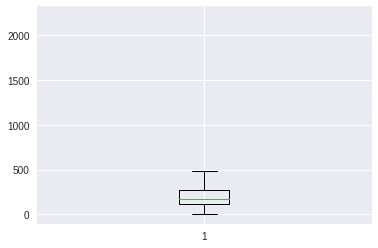

In [89]:
plt.boxplot(num_tokens)
#plt.show()

The average number of tokens in a sequence is:

In [90]:
np.mean(num_tokens)

221.27716

The maximum number of tokens in a sequence is:

In [91]:
np.max(num_tokens)

2209

The max number of tokens we will allow is set to the average plus 2 standard deviations.

In [92]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

544

This covers about 95% of the data-set.

In [93]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.94526

When padding or truncating the sequences that have a different length, we need to determine if we want to do this padding or truncating 'pre' or 'post'. If a sequence is truncated, it means that a part of the sequence is simply thrown away. If a sequence is padded, it means that zeros are added to the sequence.

So the choice of 'pre' or 'post' can be important because it determines whether we throw away the first or last part of a sequence when truncating, and it determines whether we add zeros to the beginning or end of the sequence when padding. This may confuse the Recurrent Neural Network.

In [0]:
pad = 'pre'

In [0]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [0]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

We have now transformed the training-set into one big matrix of integers (tokens) with this shape:

In [97]:
x_train_pad.shape

(25000, 544)

The matrix for the test-set has the same shape:

In [98]:
x_test_pad.shape

(25000, 544)

For example, we had the following sequence of tokens above:

In [99]:
np.array(x_train_tokens[1])

array([ 584,   10, 4339,    9,   39,    3,  226,    5,   30,  224,   27,
          4,  143,  838,   18,   10,  115,  354,    9,   10,  154,  423,
         41, 1327,   18,    9, 1477,   56,  616,    2, 1986,   68,  340,
        208, 4780,   68,   30,   99,  220,    1,   64, 2145, 1130,   22,
        677,    9,   58,   25,   32,  673,  272,   11,  518,  211,  124,
       6302,    9,   13, 2628,   16, 1680, 1793,   22,   98,  698,   34,
        969,  686,   50,   22,  103, 5448,    2,  317, 2141, 7364,  244,
        172,   49,  719,   33,  142,  158,  294,   51,   89,  118,   12,
          9,   80,   26,    3, 1247,  360,   18,    9,   13,  424,    3,
        245, 1310,   21,   14,   49,   14,   48,   42, 1915,   38, 1626,
       4317,   18,   48,    6,    9,    6,  130,  278,  166,   41,    4,
        125,   95,    3,  120,    5,   76,    2,  103,   11,   17])

This has simply been padded to create the following sequence. Note that when this is input to the Recurrent Neural Network, then it first inputs a lot of zeros. If we had padded 'post' then it would input the integer-tokens first and then a lot of zeros. This may confuse the Recurrent Neural Network.

In [100]:
x_train_pad[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Tokenizer Inverse Map

For some strange reason, the Keras implementation of a tokenizer does not seem to have the inverse mapping from integer-tokens back to words, which is needed to reconstruct text-strings from lists of tokens. So we make that mapping here.

In [0]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

Helper-function for converting a list of tokens back to a string of words.

In [0]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

For example, this is the original text from the data-set:

In [103]:
x_train_text[1]

"OK, I overrated it just a bit to offset at least one of those grumpy reviews. But I did enjoy it. I didn't laugh out loud, but it held my interest and pulled me along without dropping me at any point. The story built. Yeah, you knew it would have an happy ending--this genre always does. Meantime, it was quirky with sight gags you could miss, so pay attention when you watch. Stiller and Black delivered expertly yet again. Good team. They should work together more. Don't know that it will be a cult classic, but it was certainly a fun ride. Not as good as WHAT ABOUT BOB, or DIRTY ROTTEN SCOUNDRELS but what is? It is still worth going out of your way a little to get and watch this movie."

We can recreate this text except for punctuation and other symbols, by converting the list of tokens back to words:

In [104]:
tokens_to_string(x_train_tokens[1])

"ok i overrated it just a bit to at least one of those reviews but i did enjoy it i didn't laugh out loud but it held my interest and pulled me along without dropping me at any point the story built yeah you knew it would have an happy ending this genre always does meantime it was quirky with sight gags you could miss so pay attention when you watch stiller and black delivered expertly yet again good team they should work together more don't know that it will be a cult classic but it was certainly a fun ride not as good as what about bob or dirty rotten but what is it is still worth going out of your way a little to get and watch this movie"

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. 

In [0]:
model = Sequential()

The first layer in the RNN is a so-called Embedding-layer which converts each integer-token into a vector of values. This is necessary because the integer-tokens may take on values between 0 and 10000 for a vocabulary of 10000 words. The RNN cannot work on values in such a wide range. The embedding-layer is trained as a part of the RNN and will learn to map words with similar semantic meanings to similar embedding-vectors, as will be shown further below.

The size of the embedding-vector is typically selected between 100-300, but it seems to work reasonably well with small values for Sentiment Analysis.

In [0]:
embedding_size = 8

The embedding-layer also needs to know the number of words in the vocabulary (`num_words`) and the length of the padded token-sequences (`max_tokens`). We also give this layer a name because we need to retrieve its weights further below.

In [0]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [0]:
model.add(GRU(units=16, return_sequences=True))

This adds the second GRU with 8 output units. This will be followed by another GRU so it must also return sequences.

In [0]:
model.add(GRU(units=8, return_sequences=True))

This adds the third and final GRU with 4 output units. This will be followed by a dense-layer, so it should only give the final output of the GRU and not a whole sequence of outputs.

In [0]:
model.add(GRU(units=4))

We add a fully-connected / dense layer which computes a value between 0.0 and 1.0 that will be used as the classification output.

In [0]:
model.add(Dense(1, activation='sigmoid'))

We Use the Adam optimizer with the given learning-rate.

In [0]:
optimizer = Adam(lr=1e-3)

Compile the Keras model so it is ready for training.

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [116]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 544, 8)            80000     
_________________________________________________________________
gru_1 (GRU)                  (None, 544, 16)           1200      
_________________________________________________________________
gru_2 (GRU)                  (None, 544, 8)            600       
_________________________________________________________________
gru_3 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 81,961
Trainable params: 81,961
Non-trainable params: 0
_________________________________________________________________


## Train the Recurrent Neural Network

We can now train the model. Note that we are using the data-set with the padded sequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

In [117]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=3, batch_size=64)

Train on 23750 samples, validate on 1250 samples
Epoch 1/3
23750/23750 [==============================] - 1321s 56ms/step - loss: 0.6525 - acc: 0.5960 - val_loss: 0.5201 - val_acc: 0.7368
Epoch 2/3
10304/23750 [============>.................] - ETA: 12:22 - loss: 0.4657 - acc: 0.789523750/23750 [==============================] - 1337s 56ms/step - loss: 0.4352 - acc: 0.8069 - val_loss: 0.3637 - val_acc: 0.8480
Epoch 3/3
23296/23750 [============================>.] - ETA: 25s - loss: 0.3204 - acc: 0.871723750/23750 [==============================] - 1332s 56ms/step - loss: 0.3205 - acc: 0.8717 - val_loss: 0.3071 - val_acc: 0.8848
CPU times: user 1h 17min 45s, sys: 16min 5s, total: 1h 33min 51s
Wall time: 1h 6min 32s


## Performance on Test-Set

Now that the model has been trained we can calculate its classification accuracy on the test-set.

In [119]:
%%time
result = model.evaluate(x_test_pad, y_test)

25000/25000 [==============================] - 709s 28ms/step
CPU times: user 9min 52s, sys: 2min 6s, total: 11min 59s
Wall time: 11min 48s


In [120]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 86.14%


## Example of Mis-Classified Text

In order to show an example of mis-classified text, we first calculate the predicted sentiment for the first 1000 texts in the test-set.

In [122]:
%%time
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

CPU times: user 24.9 s, sys: 4.99 s, total: 29.8 s
Wall time: 29.4 s


In [123]:
type(y_pred)

numpy.ndarray

In [136]:
np.max(y_pred)

0.9662536

In [137]:
np.min(y_pred)

0.03415473

These predicted numbers fall between 0.0 and 1.0. We use a cutoff / threshold and say that all values above 0.5 are taken to be 1.0 and all values below 0.5 are taken to be 0.0. This gives us a predicted "class" of either 0.0 or 1.0.

In [0]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

The true "class" for the first 1000 texts in the test-set are needed for comparison.

In [0]:
cls_true = np.array(y_test[0:1000])

We can then get indices for all the texts that were incorrectly classified by comparing all the "classes" of these two arrays.

In [0]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

Of the 1000 texts used, how many were mis-classified?

In [141]:
len(incorrect)

132

Let us look at the first mis-classified text. We will use its index several times.

In [142]:
idx = incorrect[0]
idx

6

The mis-classified text is:

In [143]:
text = x_test_text[idx]
text

'<br /><br />..this movie being one of them.<br /><br />I remember, in the middle of the movie, me and my friend just<br /><br />looked at each other, shaked our heads and laughed.. in despair.<br /><br />See it if you wish, if you feel that you have the time to waste<br /><br />and don´t mind 1.5 hrs of catatonia.'

These are the predicted and true classes for the text:

In [144]:
y_pred[idx]

0.5374587

In [145]:
cls_true[idx]

0

## New Data

Let us try and classify new texts that we make up. Some of these are obvious, while others use negation and sarcasm to try and confuse the model into mis-classifying the text.

In [0]:
text1 = "This movie is fantastic! I really like it because it is so good!"
text2 = "Good movie!"
text3 = "Maybe I like this movie."
text4 = "Meh ..."
text5 = "If I were a drunk teenager then this movie might be good."
text6 = "Bad movie!"
text7 = "Not a good movie!"
text8 = "This movie really sucks! Can I get my money back please?"
texts = [text1, text2, text3, text4, text5, text6, text7, text8]

We first convert these texts to arrays of integer-tokens because that is needed by the model.

In [0]:
tokens = tokenizer.texts_to_sequences(texts)

To input texts with different lengths into the model, we also need to pad and truncate them.

In [148]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
tokens_pad.shape

(8, 544)

We can now use the trained model to predict the sentiment for these texts.

In [149]:
model.predict(tokens_pad)

array([[0.9458151 ],
       [0.93534666],
       [0.8199184 ],
       [0.9278485 ],
       [0.7276261 ],
       [0.41638756],
       [0.901975  ],
       [0.19753915]], dtype=float32)

A value close to 0.0 means a negative sentiment and a value close to 1.0 means a positive sentiment. These numbers will vary every time you train the model.

## Embeddings

The model cannot work on integer-tokens directly, because they are integer values that may range between 0 and the number of words in our vocabulary, e.g. 10000. So we need to convert the integer-tokens into vectors of values that are roughly between -1.0 and 1.0 which can be used as input to a neural network.

This mapping from integer-tokens to real-valued vectors is also called an "embedding". It is essentially just a matrix where each row contains the vector-mapping of a single token. 

Ideally the embedding would learn a mapping where words that are similar in meaning also have similar embedding-values. Let us investigate if that has happened here.

First we need to get the embedding-layer from the model:

In [0]:
layer_embedding = model.get_layer('layer_embedding')

We can then get the weights used for the mapping done by the embedding-layer.

In [0]:
weights_embedding = layer_embedding.get_weights()[0]

Note that the weights are actually just a matrix with the number of words in the vocabulary times the vector length for each embedding. That's because it is basically just a lookup-matrix.

In [152]:
weights_embedding.shape

(10000, 8)

Let us get the integer-token for the word 'good', which is just an index into the vocabulary.

In [153]:
token_good = tokenizer.word_index['good']
token_good

49

Let us also get the integer-token for the word 'great'.

In [154]:
token_great = tokenizer.word_index['great']
token_great

78

These integertokens may be far apart and will depend on the frequency of those words in the data-set.

Now let us compare the vector-embeddings for the words 'good' and 'great'. Several of these values are similar, although some values are quite different. Note that these values will change every time you train the model.

In [155]:
weights_embedding[token_good]

array([0.06978175, 0.3294625 , 0.7378722 , 0.6928707 , 1.0304365 ,
       0.56373334, 0.75720555, 0.15286215], dtype=float32)

In [156]:
weights_embedding[token_great]

array([-0.08951966,  0.16427216,  0.6002284 ,  0.25142065,  0.70907444,
        0.3805157 ,  1.2637105 ,  1.340202  ], dtype=float32)

Similarly, we can compare the embeddings for the words 'bad' and 'horrible'.

In [0]:
token_bad = tokenizer.word_index['bad']
token_horrible = tokenizer.word_index['horrible']

In [158]:
weights_embedding[token_bad]

array([ 0.73793083,  1.2536905 ,  0.258222  ,  0.67009264,  0.12766917,
        0.6115064 , -0.35816061,  0.13285272], dtype=float32)

In [159]:
weights_embedding[token_horrible]

array([ 0.77908665,  0.40023726, -0.3966847 ,  0.73980194, -0.123175  ,
        1.2361107 , -0.06143235,  0.23452836], dtype=float32)

### Sorted Words

We can also sort all the words in the vocabulary according to their "similarity" in the embedding-space. We want to see if words that have similar embedding-vectors also have similar meanings.

Similarity of embedding-vectors can be measured by different metrics, e.g. Euclidean distance or cosine distance.

We have a helper-function for calculating these distances and printing the words in sorted order.

In [0]:
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]
    
    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)
    
    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]
    
    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

We can then print the words that are near and far from the word 'great' in terms of their vector-embeddings. Note that these may change each time you train the model.

In [161]:
print_sorted_words('great', metric='cosine')

Distance from 'great':
0.000 - great
0.026 - mrs
0.034 - ride
0.036 - dawn
0.037 - rules
0.038 - nerves
0.038 - haunting
0.042 - finest
0.042 - stops
0.042 - miyazaki
...
0.889 - awful
0.906 - worst
0.911 - lacks
0.917 - waste
0.927 - overrated
0.932 - worse
0.934 - avoid
0.941 - baldwin
1.007 - mess
1.009 - 4


Similarly, we can print the words that are near and far from the word 'worst' in terms of their vector-embeddings.

In [162]:
print_sorted_words('worst', metric='cosine')

Distance from 'worst':
0.000 - worst
0.032 - awful
0.036 - flimsy
0.041 - waste
0.045 - failed
0.049 - shout
0.050 - poor
0.050 - forgettable
0.050 - terrible
0.051 - flop
...
1.086 - noir
1.090 - restored
1.103 - awesome
1.104 - timon
1.133 - 8
1.142 - dvds
1.148 - dancers
1.158 - choreographed
1.179 - 7
1.217 - 9


## Conclusion

This shows the basic methods for doing Natural Language Processing (NLP) using a Recurrent Neural Network with integer-tokens and an embedding layer. This was used to do sentiment analysis of movie reviews from IMDB.